In [1]:
# Loading the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

In [8]:
# Loading the data with reviews and ratings produced using scrape_reviews.inpynb
reviews=pd.read_csv("~/jupyterlab/amazon-reviews/data-2.csv",sep=",")

In [3]:
# Checking the number of registries for each rating
reviews.groupby(by='rating').count()

,title,content,country,date,images,verified,author,product,variant,url
rating,,,,,,,,,,
1.0,1831,1831,1832,1832,93,1832,1832,1832,1832,1832
2.0,790,790,790,790,30,790,790,790,789,790
3.0,841,841,841,841,29,841,841,841,841,841
4.0,935,934,935,935,44,935,935,935,935,935
5.0,1990,1990,1990,1990,117,1990,1990,1990,1990,1990


In [4]:
# Defining a list with the review and the title summed
reviews_text=reviews['content']+" "+reviews['title']

In [5]:
# One big text with alle the reviews
text=str(list(reviews_text))

In [6]:
# Function for cleaning up the text from useless symbols
def clean_up(text,option):
    text = re.sub(r'==.*?==+', ' ', text)
    text = text.replace("’","'") # important
    text = text.replace("\\xa0"," ")
    text = text.replace('.','. ')
    text = text.replace('\n', ' ')
    text = text.replace("\'", "'")
    text = text.replace("\\\'", "'")
    text = text.replace("[","")
    text = text.replace("]","")
    text = text.replace("—"," ")
    text = text.replace("-"," ")
    text = text.replace("U.S","US")
    text = text.replace("D.C","DC")
    text = text.replace("p.m","pm")
    text = text.replace("a.m","am")
    text = text.replace(" '"," ")
    text = text.replace("' "," ")
    text = text.replace("\\ "," ")
    text = text.replace('“'," ")
    text = text.replace('”'," ")
    text = text.replace('"'," ")
    text = text.replace('\\\\'," ")
    text = text.replace('*'," ")
    text = text.replace('⭐️'," ")
    text=re.sub('[,\.!?/()]¿¡', ' ', text)
    text=text.lower()
# New text string
    new_text=''
# New text string only with letters "'" and spaces
    for letter in text:
        if letter.isalpha() or (letter=="'" or letter==' '):
            new_text+=letter
        else:
            new_text+=' '
# Option to cut first and last character applies here
    if option: new_text=new_text[1:-1]
    new_text = new_text.replace("' "," ")
    new_text = new_text.replace(" '"," ")
    return new_text

In [7]:
# Cleaning up the text
new_text=clean_up(text,True)

In [8]:
# Splitting text into words
words_list=new_text.split()

In [9]:
# Final clean up of words
words_list=[x for x in words_list if x.isalpha() or x.find("'")]

In [10]:
# Number of unique words (to cross-check later)
len(list(set(words_list)))

9443

In [11]:
# We count the unique words here using pandas data frame value_counts()
word_counts=list(pd.DataFrame(words_list).value_counts())

In [12]:
# We extract the "pre-list" of unique words using pandas data frame index
aux=list(pd.DataFrame(words_list).value_counts().index)

In [13]:
# Getting the words from the pre-list
words=[x[0] for x in aux]

In [14]:
# The number of unique words agrees with the previous result
print('Number of unique words:',len(words))

Number of unique words: 9443


In [17]:
# Defining zero numpy arrays for counting
rats=np.zeros(len(words)) # ratings
rats2=np.zeros(len(words)) # ratings squared
counts=np.zeros(len(words)) # counts

In [18]:
# Cleaning up reviews: now one by one
reviews['text']=[clean_up(str(txt),False) for txt in reviews_text]

In [19]:
# Lists to store words and data frame with words and counts for each review 
words_l=[]
df_l=[]
# Filling words_l and df_l
for j in range(0,len(reviews['text'])):
    words_l.append(reviews['text'][j].split())
    words_l[j]=[x for x in words_l[j] if x.isalpha() or x.find("'")]
    df_l.append(pd.DataFrame(words_l[j],dtype=str).value_counts())

# Loop with counting and calculating sums waited with ratings
for i in range(0,len(words)):
    for j in range(0,len(reviews['text'])):
        try:
            cnt=int(df_l[j][words[i]]) # Getting the count for a word
        except KeyError:
            cnt=0
        counts[i]+=cnt # Summing the counts
        rats[i]+=cnt*(reviews['rating'][j]-3.)/2. # Summing the counts weighted with ratings
        rats2[i]+=cnt*np.square((reviews['rating'][j]-3.)/2.) # Summing the counts weighted with ratings squared
# Calculating average values
rats=rats/counts
rats2=rats2/counts
std=np.sqrt(rats2-np.square(rats))
counts=counts.astype('int64') # Changing the type of counts

In [90]:
# Array prepared to fill a data frame
array=list(np.transpose(np.array([words,rats,counts,std])))

In [91]:
# Data frame with results
df=pd.DataFrame(array,columns=['words','values','count','error'])

In [94]:
# Changing columns to propper types
df['count']=df['count'].astype('int64')
df['values']=df['values'].astype('float64')
df['error']=df['error'].astype('float64')

In [95]:
# Storing the result into csv, because the loop above takes a bit time
df.to_csv('amazon_words.csv', sep=",", index=True)

In [2]:
# Reading the data frame if needed
df=pd.read_csv("amazon_words.csv",sep=",")

In [3]:
# Removing NaNs
df_new=df.sort_values(by='values').dropna()

In [4]:
# Storing into csv to use in other data visualisation software
df_new.to_csv('amazon_words_df_new.csv', sep=",", index=True)

In [16]:
# Setting parameters for filtering
negmax=-0.35 # Maximal negative value
posmin=0.25 # Minimal positive value
count_lim=500 # Parameter for filtering counts above count_lim

In [17]:
# Applying the filter
df_new_bSel=df_new[(df_new['count']>count_lim) & ((df_new['values']<negmax) | (df_new['values']>posmin))]
len_df=len(df_new_bSel)
# Printing number of points kept
print(len_df)

17


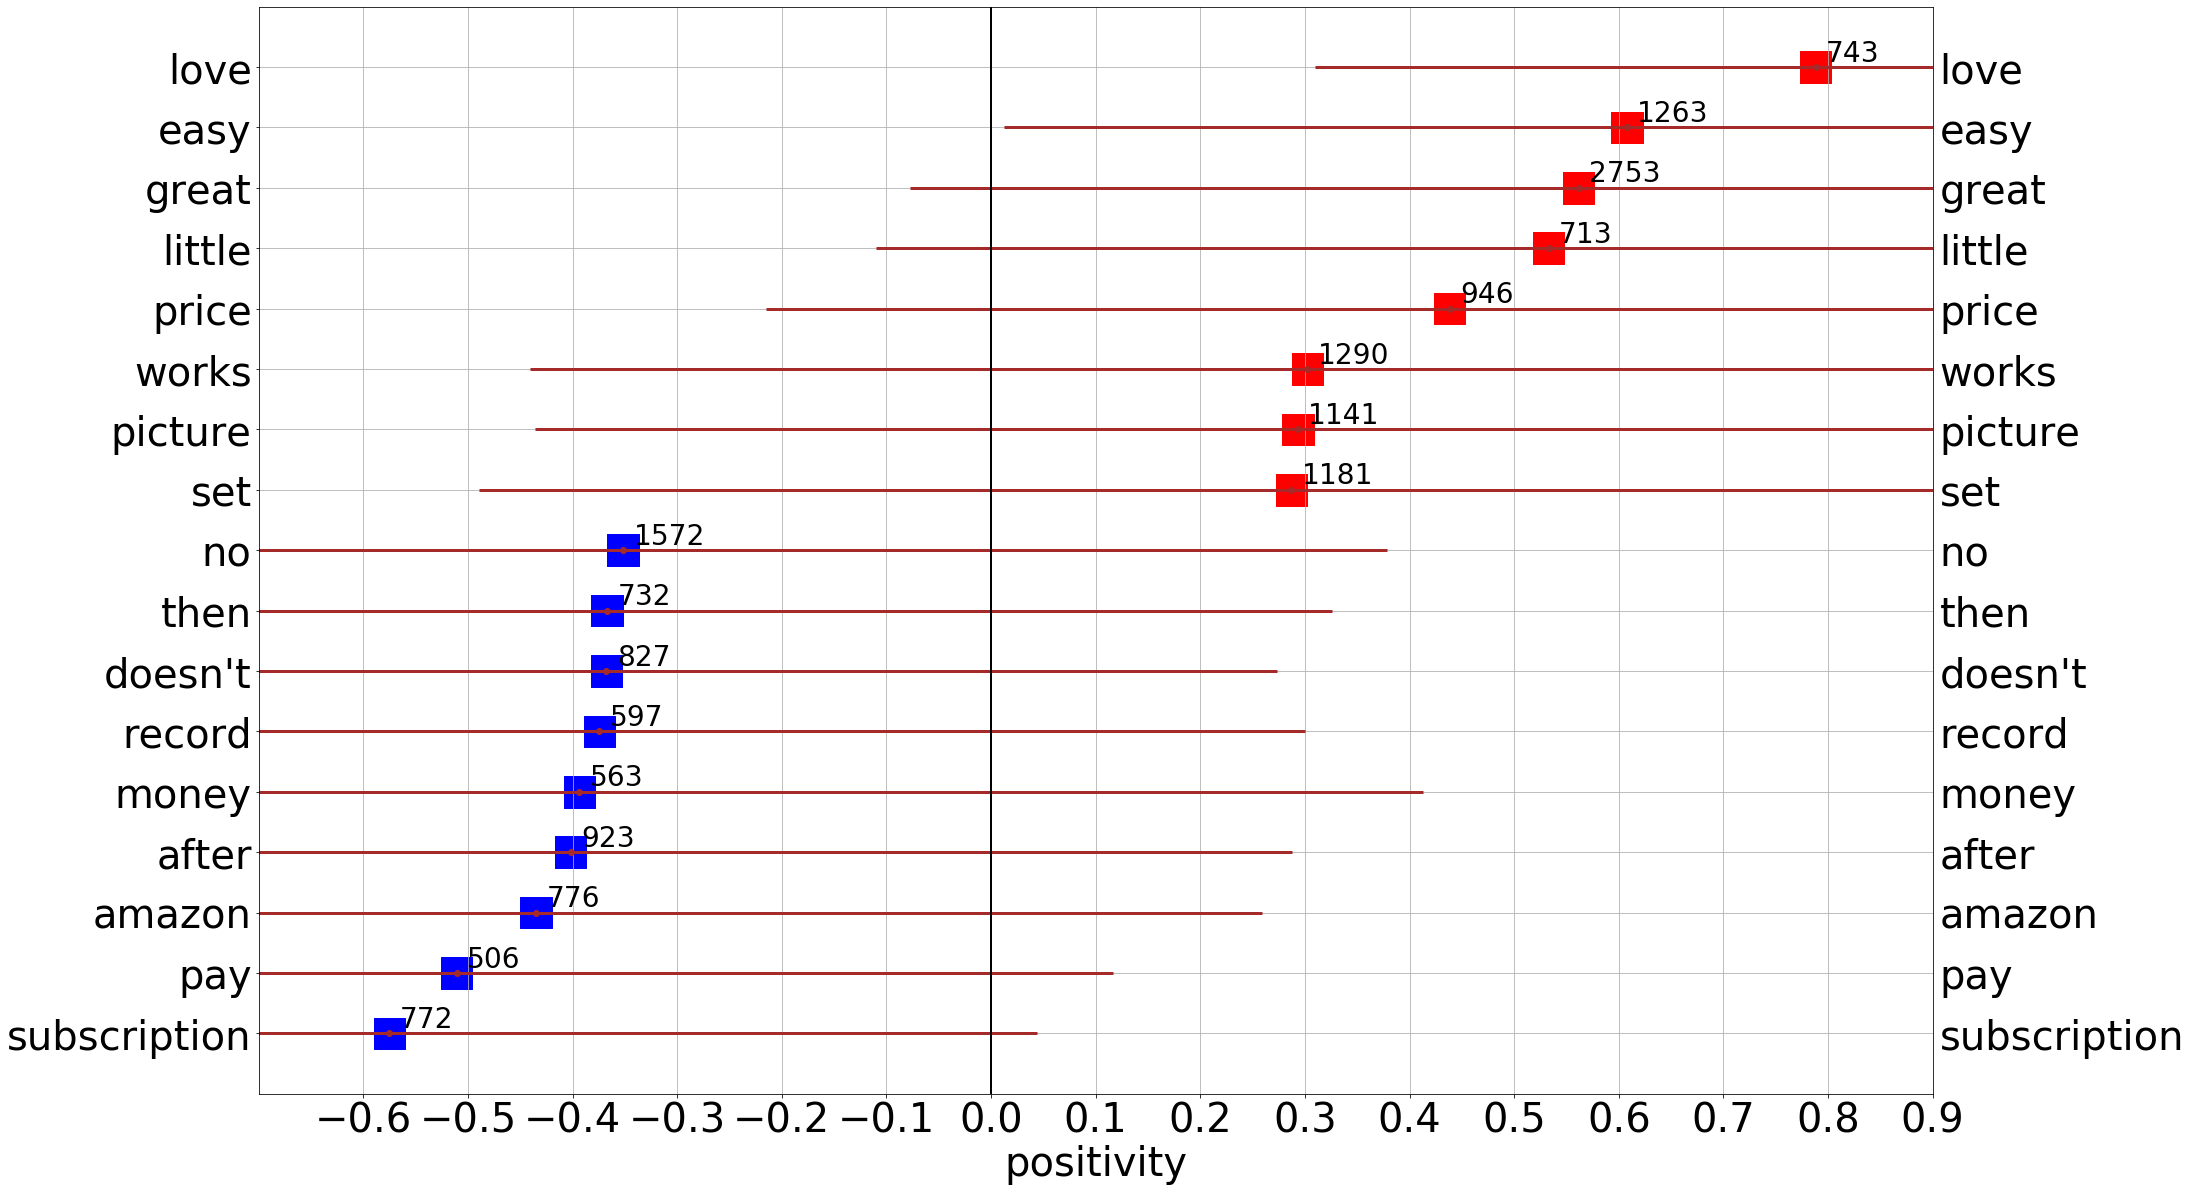

In [19]:
# Plotting
plt.rcParams["figure.figsize"] = (30,20)
colors = np.where(df_new_bSel["values"]>0,'r','b')
plt.scatter(df_new_bSel['values'],df_new_bSel['words'],color=colors,label='data',s=1000,marker='s')
plt.errorbar(df_new_bSel['values'],df_new_bSel['words'],xerr=df_new_bSel['error'], fmt='o',color='brown',elinewidth=3)
plt.plot([0,0],[-1,len_df],color='black',linewidth=2)
plt.ylim(-1,len_df)
plt.xlim(-0.7,0.9)

plt.tick_params(axis='y', which='both', labelleft=True, labelright=True)
plt.yticks(fontsize=40,color='black')

plt.xticks(np.arange(-0.6,1.,0.1),fontsize=40)
plt.xlabel('positivity',fontsize=40,color='black')
plt.grid()
for i in range(0,len_df):
    plt.text(df_new_bSel['values'].iloc[i]+0.01,i,df_new_bSel['count'].iloc[i],horizontalalignment='left',verticalalignment='bottom',fontsize=28)
plt.savefig('reviews_plot.png')
print()

In [12]:
# Setting parameters for filtering
negmax3=0 # Maximal negative value
posmin3=0 # Minimal positive value
count_lim3=50 # Parameter for filtering counts above count_lim

In [13]:
# Applying the filter
df_new_bSel3=df_new[(df_new['count']>count_lim3) & ((df_new['values']<negmax3) | (df_new['values']>posmin3))]
len_df=len(df_new_bSel3)
# Printing number of points kept
print(len_df)

812


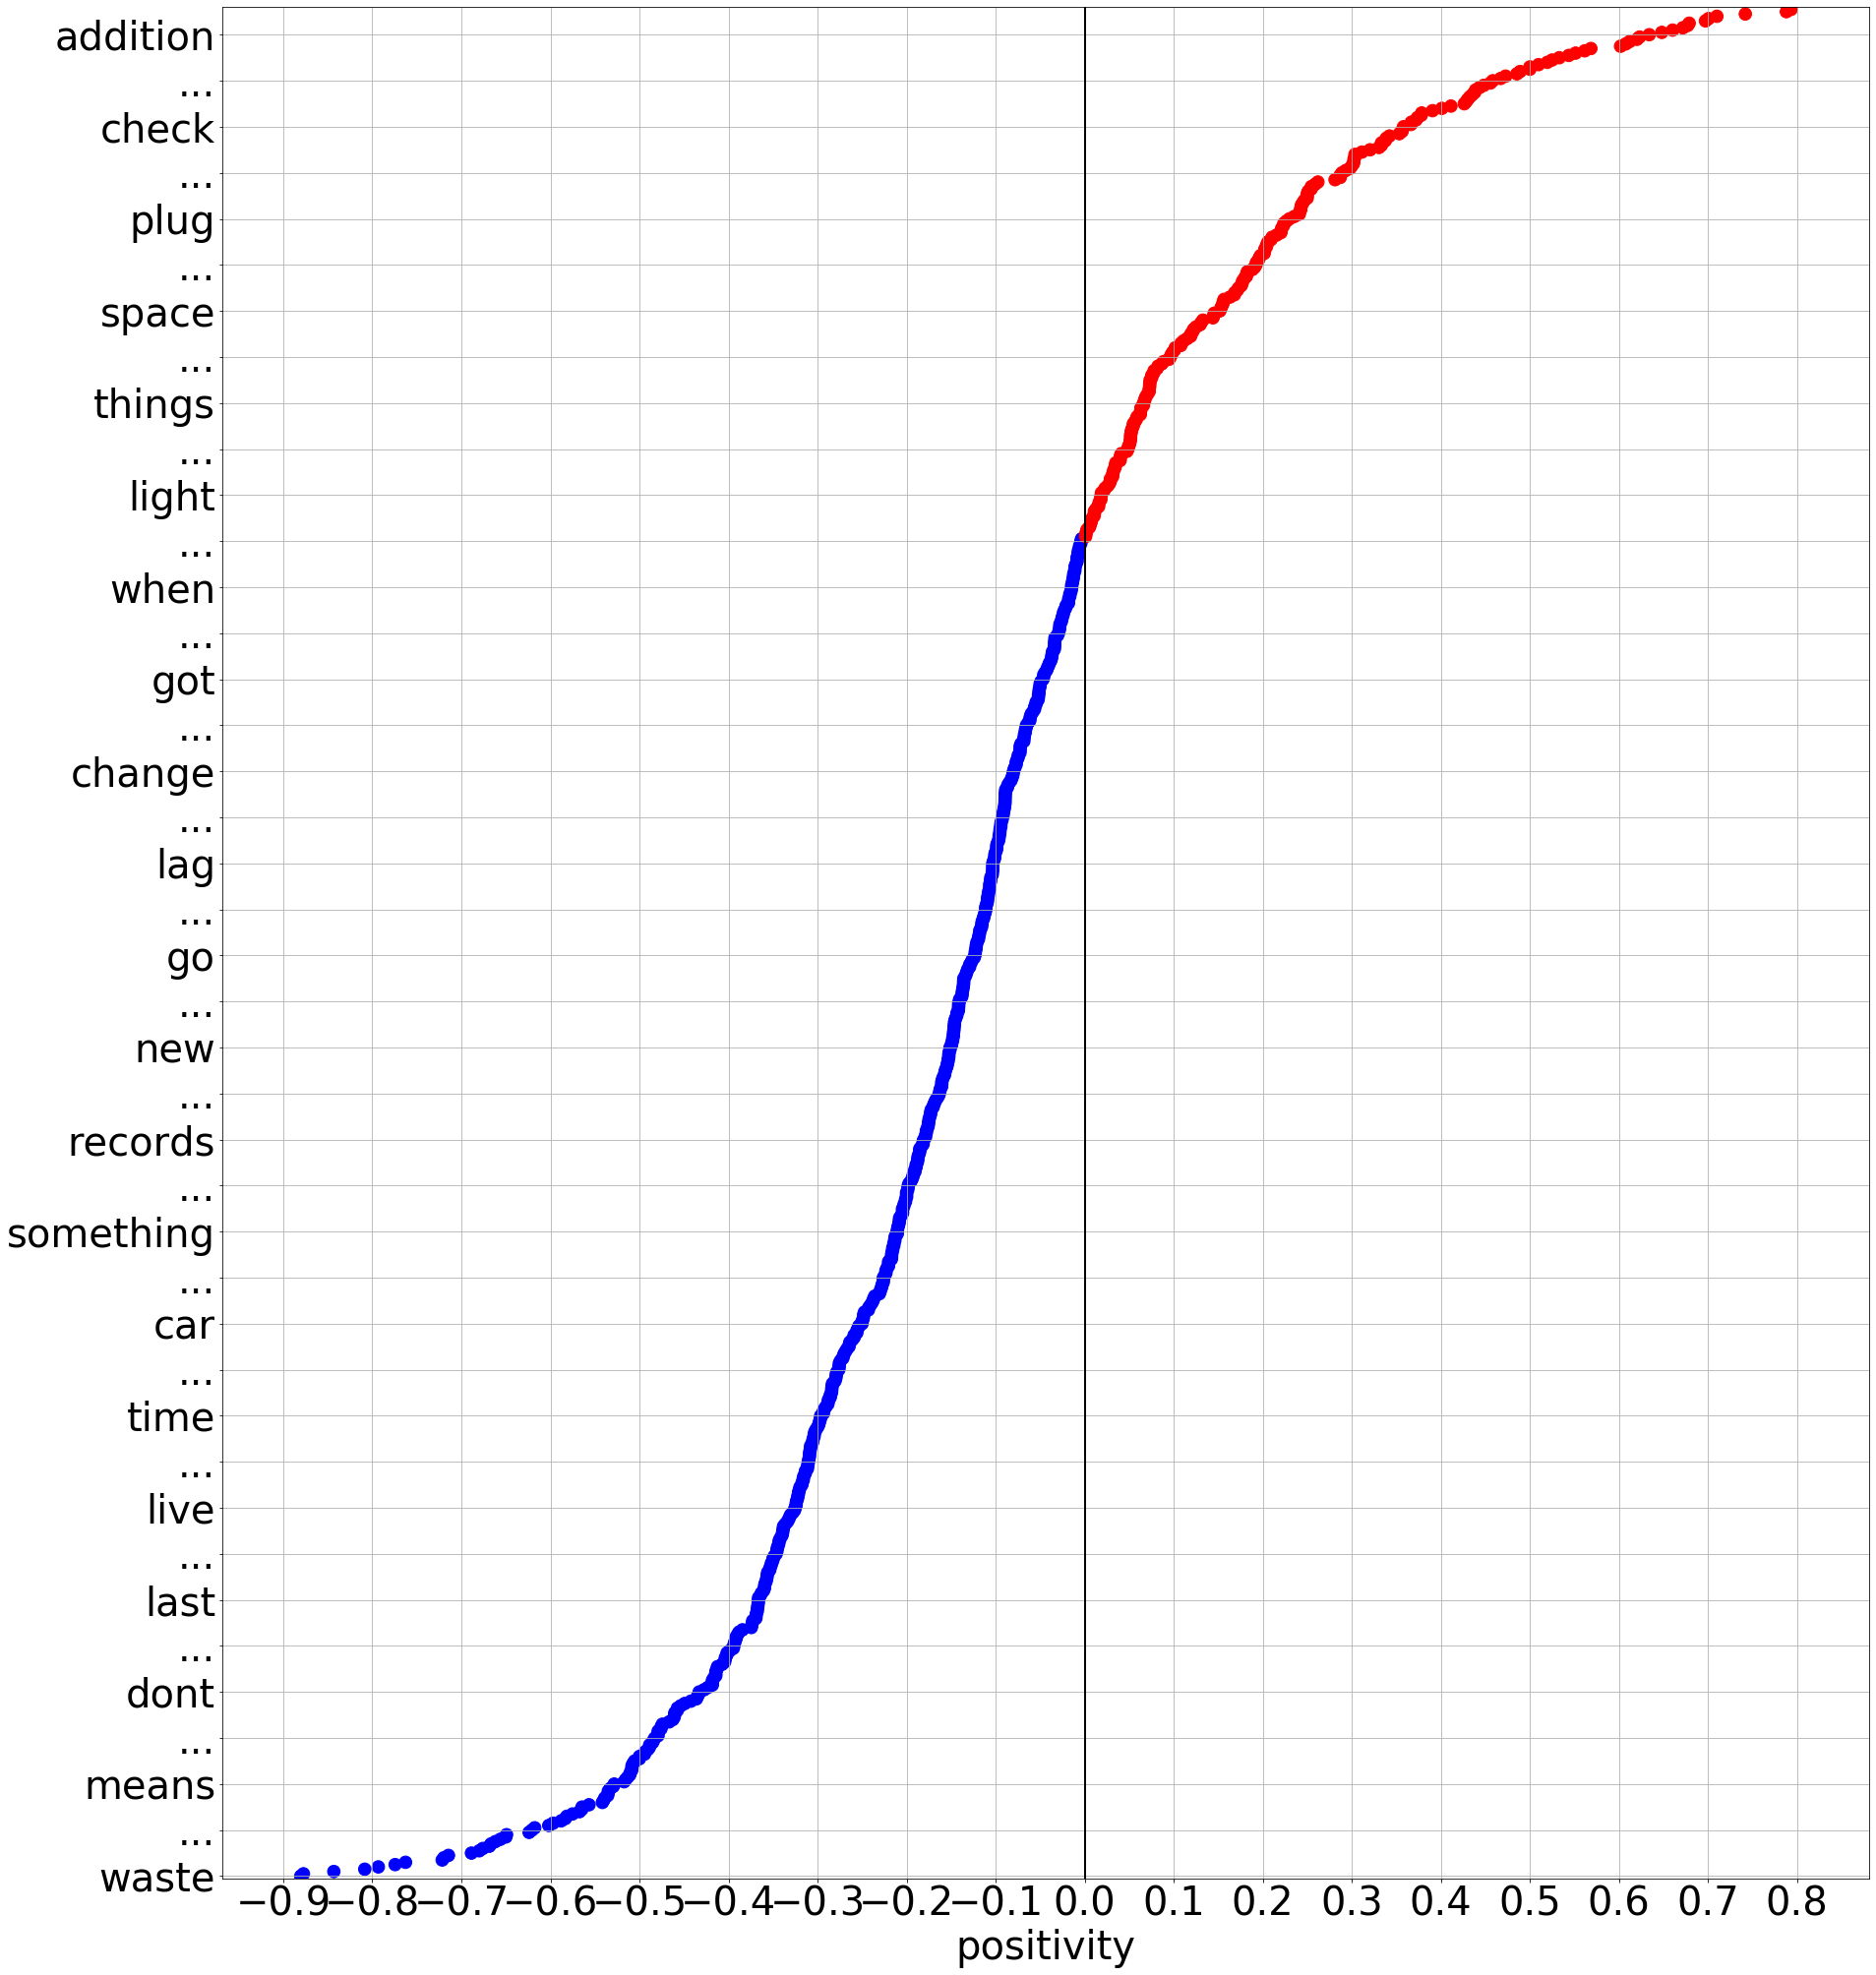

In [14]:
# Plotting
plt.rcParams["figure.figsize"] = (30,35)
colors = np.where(df_new_bSel3["values"]>0,'r',np.where(df_new_bSel3["values"]==0,'g','b'))
plt.scatter(df_new_bSel3['values'],df_new_bSel3['words'],color=colors,label='data',s=160)

plt.plot([0,0],[-1,len_df],color='black',linewidth=2)
plt.ylim(-1,len_df)
plt.tick_params(axis='y', which='both', labelleft=True, labelright=False)

plt.yticks([x for x in range(0,len_df,int(len_df/40))],labels=[np.where(i%40==0,(df_new_bSel3.reset_index())['words'][i],'...') for i in range(0,len_df,int(len_df/40))],fontsize=40)
plt.xticks(np.arange(round(min(df_new_bSel3['values']),1),round(max(df_new_bSel3['values']),1)+0.1,0.1),fontsize=40)
plt.xlabel('positivity',fontsize=40,color='black')
plt.grid()
plt.savefig('reviews_ilustration.png')

print()